In [2]:
%matplotlib inline

import os
import operator as op
import functools as ft
import warnings
from glob import glob

import cv2
import matplotlib as m
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

warnings.filterwarnings('ignore')

In [3]:
def get_hist_sim(hist1, hist2):
    assert hist1.shape == hist2.shape
    
    sim = 0.0
    for i in range(hist1.shape[0]):
        sim += np.linalg.norm(hist1[i]-hist2[i])
    return sim/len(hist1)

In [9]:
dataset_dir = os.path.join('data', 'dataset', 'index', '*')
dataset_files = glob(os.path.join(dataset_dir, '*'))

In [10]:
dataset = {}

for path in dataset_files:
    class_dir, filename = os.path.split(path)
    class_name = os.path.basename(class_dir)
 
    if not class_name in dataset:
        dataset[class_name] = {}
    
    dataset[class_name][filename] = {
        'filename': filename,
        'path': path, 
    }

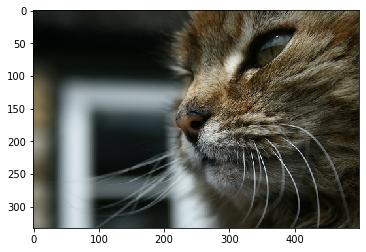

In [11]:
image_path = dataset_files[2]
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

## What is an Image Histogram?
- It is a graphical representation of the intensity distribution of an image.
- It quantifies the number of pixels for each intensity value considered.

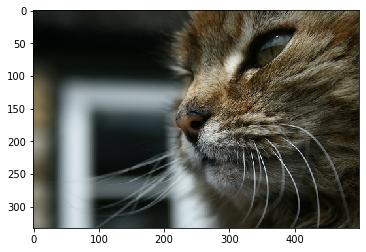

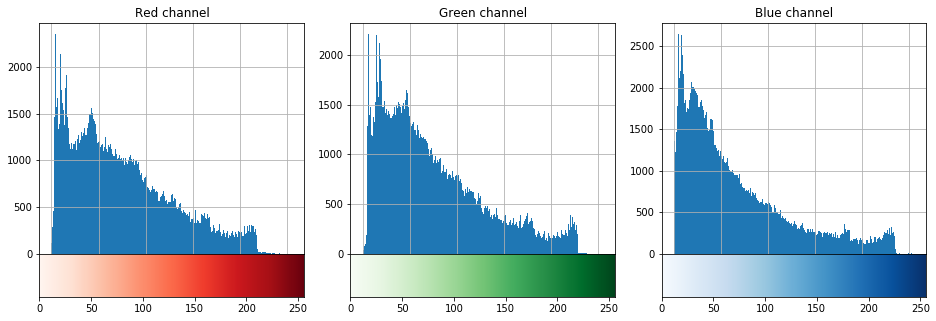

In [12]:
cmaps = [
    m.cm.Reds, 
    m.cm.Greens,
    m.cm.Blues
]

hist_size = 256
hist_range = (0, 256)
color_range = [np.arange(0, 256)]
plt.imshow(image)

fig = plt.figure(figsize=(16, 4))
for i, channel in enumerate(cv2.split(image)):
    title = cmaps[i].name[:-1] + ' channel'
#     ax = fig.add_subplot(1, image.shape[-1], i+1)
    ax = fig.add_axes([0.27*i, 0.15, 0.23, 0.8], label=title)
    ax.hist(channel.flatten(), hist_size, hist_range)
    ax.set_title(title)
    ax.grid()
    
#     ax = fig.add_subplot(2, image.shape[-1], i+4)
    ax = fig.add_axes([0.27*i, 0, 0.23, 0.15], label=title)
    ax.pcolormesh(color_range, cmap=cmaps[i])
    ax.yaxis.set_visible(False)

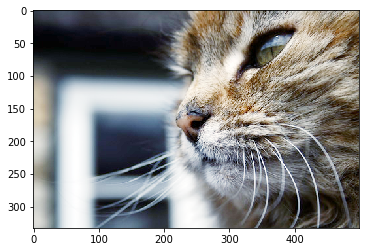

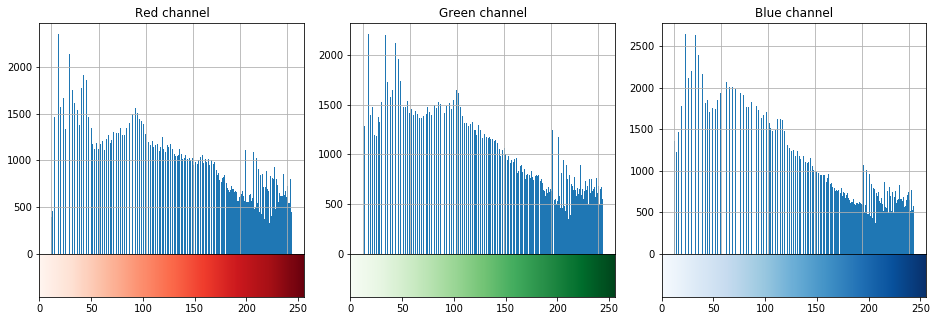

In [13]:
cmaps = [
    m.cm.Reds, 
    m.cm.Greens,
    m.cm.Blues
]

hist_size = 256
hist_range = (0, 256)
color_range = [np.arange(0, 256)]

eq_images = list(map(lambda x: cv2.equalizeHist(x), cv2.split(image)))
eq_images = np.array(eq_images).transpose(1,2,0)

plt.imshow(eq_images)

fig = plt.figure(figsize=(16, 4))
for i, channel in enumerate(cv2.split(eq_images)):
    channel = cv2.equalizeHist(channel)
    title = cmaps[i].name[:-1] + ' channel'
#     ax = fig.add_subplot(1, image.shape[-1], i+1)
    ax = fig.add_axes([0.27*i, 0.15, 0.23, 0.8], label=title)
    ax.hist(channel.flatten(), hist_size, hist_range)
    ax.set_title(title)
    ax.grid()
    
#     ax = fig.add_subplot(2, image.shape[-1], i+4)
    ax = fig.add_axes([0.27*i, 0, 0.23, 0.15], label=title)
    ax.pcolormesh(color_range, cmap=cmaps[i])
    ax.yaxis.set_visible(False)

# Compute features

In [15]:
hist_size = 48 # as for the paper
hist_range = (0, 256) # RGB range

for class_name, values in tqdm(dataset.items()):
    outpath = os.path.join('data', 'features', 'hist', class_name)

    if not os.path.exists(outpath):
        os.makedirs(outpath)
    
    for filename, meta in values.items():
        image = cv2.imread(meta['path'])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pixel_count = ft.reduce(op.mul, image.shape[:-1])
        rgb_channels = cv2.split(image)
        features = []
        for channel in range(3):
            hist = cv2.calcHist(rgb_channels, [channel], None, 
                                [hist_size], hist_range, False)
            features.append(hist.flatten()/pixel_count) 
            
        outfile = os.path.join(outpath, filename+'.npy')
        with open(outfile, 'wb') as f:
            np.save(f, features)

100%|██████████| 5/5 [00:00<00:00,  9.22it/s]


# Generate query set

In [36]:
features_path = os.path.join('data', 'features', 'hist', '*') 
features_files = glob(os.path.join(features_path, '*'))

queries = {}
database = []

sorted_files = np.random.choice(features_files, size=len(features_files), 
                                replace=False)

query_set = [
    '1562305641_7e37719fc0',
    '114170569_6cbdf4bbdb',
    '406697077_61287601aa',
    '2104774157_851e88c499',
    '4504777676_83db8bcd56'
]

for path in tqdm(sorted_files):
    class_dir, filename = os.path.split(path)
    class_name = os.path.basename(class_dir)
    features = np.load(path)
    
    image_path = os.path.join('data', 'dataset', 'index', 
                              class_name, filename[:-4])
    if filename.split('.')[0] in query_set:
        # Select one image of each class
        queries[class_name] = {
            'path': image_path,
            'features': features,
            'class': class_name,
            'rank': []
        }    
    database.append({
        'path': image_path,
        'features': features,
        'class': class_name
    })

100%|██████████| 157/157 [00:00<00:00, 4375.25it/s]


# Perform retrieval test

In [37]:
for class_name, query_meta in tqdm(queries.items()):
    query_feaures = query_meta['features']
    rank = []
    for sample_meta in database:
        sample_features = sample_meta['features']
        distance = get_hist_sim(query_feaures, sample_features)
        rank.append([distance, sample_meta])
    top_5 = sorted(rank, key=lambda x: x[0])[:5]
    queries[class_name]['rank'] = top_5

100%|██████████| 5/5 [00:00<00:00, 212.09it/s]


# Dispay results

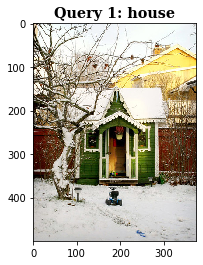

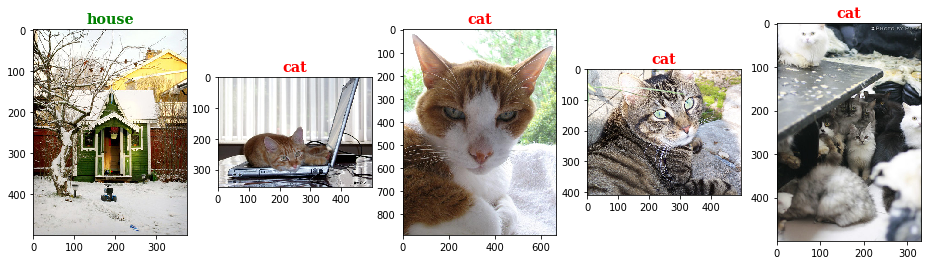

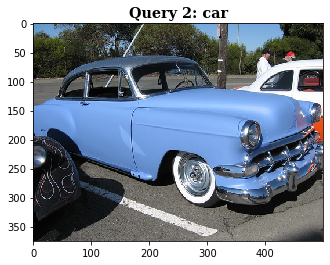

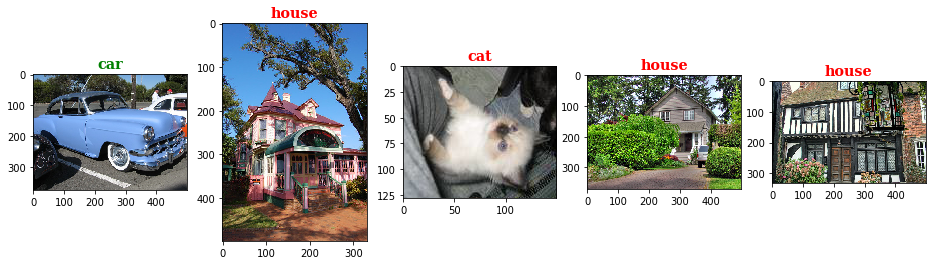

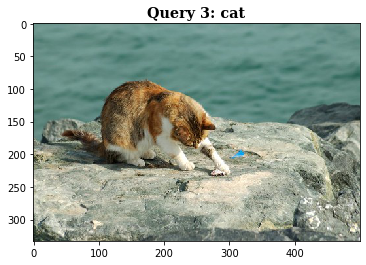

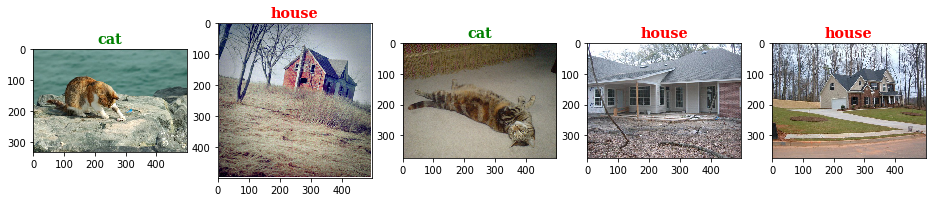

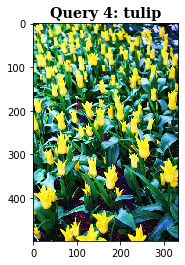

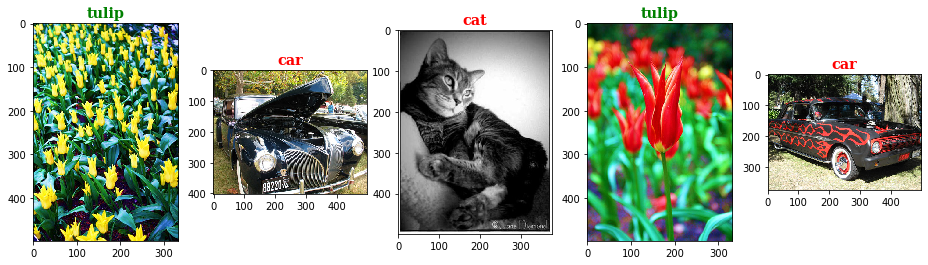

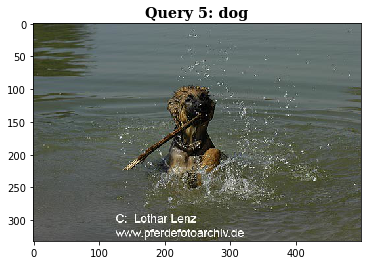

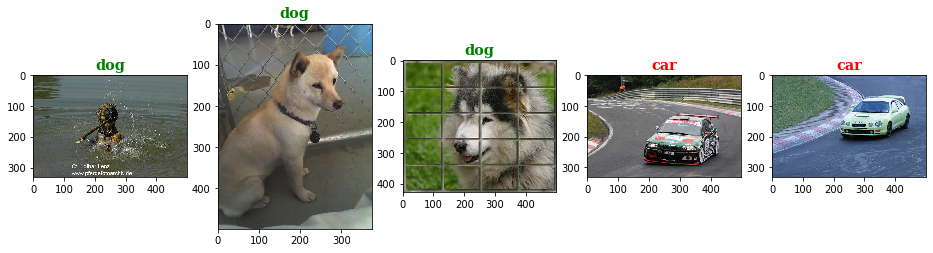

In [38]:
fontdict = {
    'fontsize': 'x-large',
    'fontweight': 'bold',
    'family': 'serif'
}

for i, (class_name, meta) in enumerate(queries.items()):
    query_image = cv2.imread(meta['path'])
    query_image = cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB)
    qclass = meta['class']
    fontdict['color'] = 'black'
    
    fig, ax = plt.subplots(1,1)
    ax.imshow(query_image)
    ax.set_title(f'Query {i+1}: {qclass}', fontdict=fontdict)
    fig = plt.figure(figsize=(16, 4))
    for j, result in enumerate(meta['rank']):
        sample_image = cv2.imread(result[1]['path'])
        sample_image = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)
        sclass = result[1]['class']
        
        if qclass == sclass:
            fontdict['color'] = 'green'
        else:
            fontdict['color'] = 'red'
        
        ax = fig.add_subplot(1, len(meta['rank']), j+1)
        ax.imshow(sample_image)
        ax.set_title(sclass, fontdict=fontdict)